In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import copy

from viz_functions import plot_extra_steps_from_file

# Visualize extra steps

## Ground only

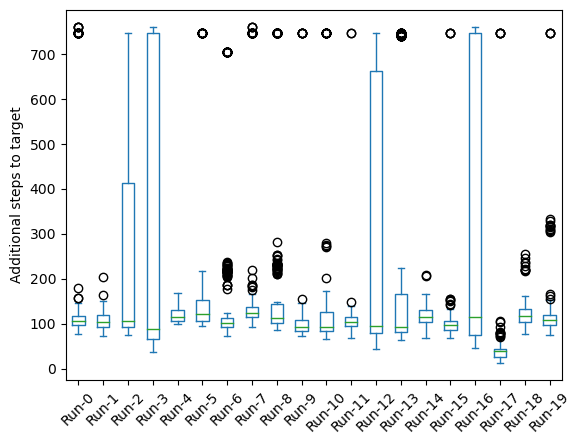

In [3]:
ground_file = './Test_Ground_FSVI_300it_100exp_099g_e6eps_20run_20231120_141253/extra_steps.csv'
plot_extra_steps_from_file(ground_file)

### Filtered unfinishes trajectories

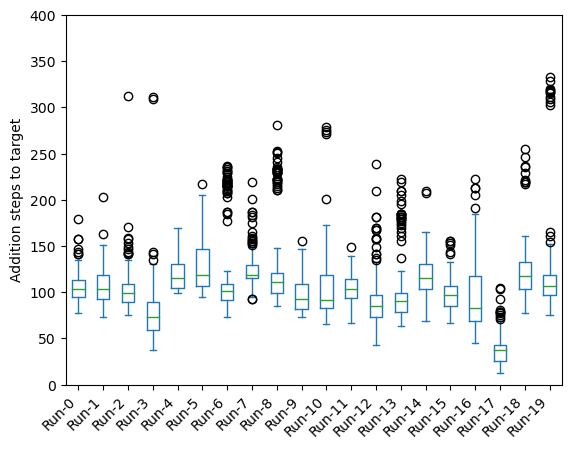

In [4]:
# Plot filtered version
df = pd.read_csv(ground_file)
df = df.drop(columns='Average')

extra_steps_array = df.to_numpy().T
extra_steps_df = pd.DataFrame(extra_steps_array, columns=[f'Run-{i}' for i in range(extra_steps_array.shape[1])])

# Filtered
filt_extra_steps_df = copy.copy(extra_steps_df)
for i in range(extra_steps_array.shape[1]):
    filt_extra_steps_df.loc[filt_extra_steps_df[f'Run-{i}']>600, [f'Run-{i}']] = np.nan

filt_extra_steps_df.plot(kind='box')
plt.ylim(0,400)
plt.ylabel('Addition steps to target')
plt.xticks(rotation=45, ha='right')
plt.show()

## Ground and air

### Test 11-21 (1)

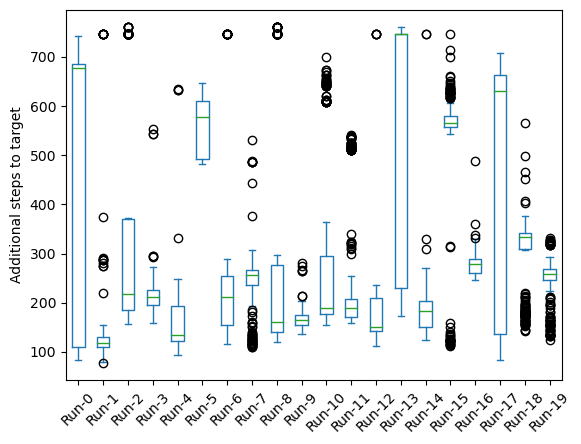

In [5]:
file = './Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_102752/extra_steps.csv'
plot_extra_steps_from_file(file)

### Test 11-21 (2)

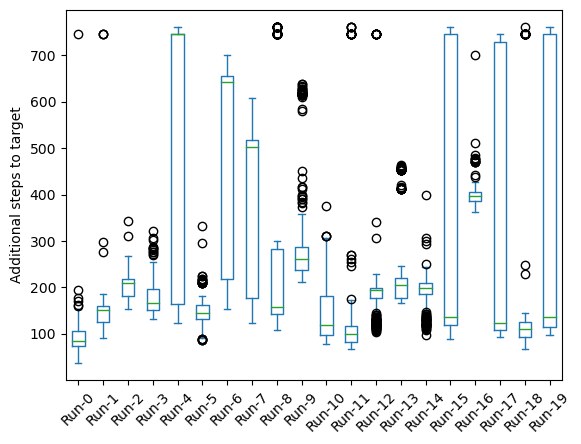

In [6]:
file = './Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/extra_steps.csv'
plot_extra_steps_from_file(file)

## Comparing different amount of expansions

In [12]:
files = {
    60: './Test_GroundAir_FSVI_400it_60exp_099g_e6eps_20run_20231122_124320/extra_steps.csv',
    80: './Test_GroundAir_FSVI_400it_80exp_099g_e6eps_20run_20231122_010724/extra_steps.csv',
    100: './Test_GroundAir_FSVI_300it_100exp_099g_e6eps_20run_20231121_165329/extra_steps.csv',
    120: './Test_GroundAir_FSVI_400it_120exp_099g_e6eps_20run_20231122_175226/extra_steps.csv'
}

average_sets = {
    e: pd.read_csv(file)['Average'].to_list() for e, file in files.items()
}

Text(0.5, 0, 'Expansion counts')

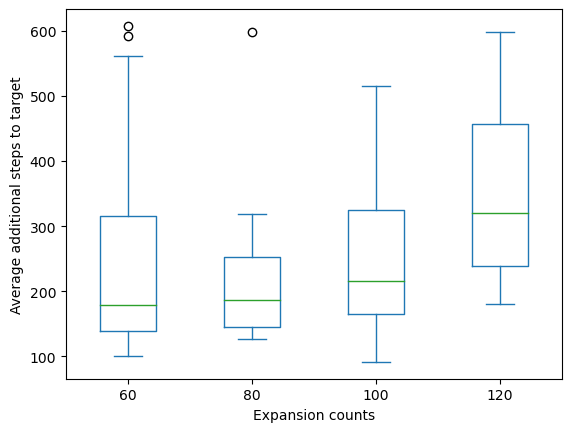

In [14]:
# Actual plot
pd.DataFrame(average_sets).plot(kind='box')
plt.ylabel('Average additional steps to target')
plt.xlabel('Expansion counts')